In [1]:
%matplotlib inline

In [6]:
import numpy as np
import pyqtgraph as pg

x = np.random.normal(size=1000)
y = np.random.normal(size=1000)

pg.plot(x, y, symbol='o')
pg.QtGui.QApplication.exec_()

0

In [7]:
__author__ = 'Christo Robison'

#This program preprocesses the data by removing artifacts caused by the snapshot HSI system

from spectral import *
import numpy as np
from scipy import fftpack as ft
import h5py
import matplotlib
#matplotlib.use('qt4')
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
from skimage import io, exposure, img_as_uint, img_as_float
import png
#io.use_plugin('freeimage')
import pyfftw

show_full_out = False
if show_full_out: np.set_printoptions(threshold=np.nan)

def getData(filename=None):
    if filename is None: filename = 'D:\-_Hyper_Spec_-\HYPER_SPEC_TEST.h5'
    f = h5py.File(filename, 'r')
    dcb = f['data'][:] #Extract normalized data for svm b/c intensity sensitive
    labels = f['labels'][:]
    bands = f['bands'][:]
    classLabels = f['classLabels'][:]
    out = {'dcb': dcb, 'labels': labels, 'lambdas': bands, 'classLabels': classLabels}
    f.close()
    return out

    
def im2png(img, filename):
    f = open(filename, 'wb')
    w = png.Writer(313, 443, greyscale=True, bitdepth=8)
    if img.dtype is not np.int8:
        if (np.amin(img) < 0): img = img - np.amin(img)
        img = np.float32(img) * (2.0**7 - 1.0)/ np.amax(img)
        img = np.int8(img)
    #img_w = exposure.rescale_intensity(img, out_range='int8')
    w.write(f, img)
    f.close()
        

def imSave(img, filename, range='float'):
    f = open(filename,'wb')
    w = png.Writer(313, 443, greyscale=True, bitdepth=8)
    img_w = exposure.rescale_intensity(img,out_range=range)
    img_w = img_as_uint(img_w)
    w.write(f, img_w)
    f.close()


def shapeData(data, labels, numExamples, numBands, altDims = None):
    '''Takes input data matrix and reshapes it into HW,D format
    i.e. endmembers and their appropriate class labels'''
    if altDims is None: altDims = [443, 313, numBands, numExamples]
    temp = np.reshape(data, altDims, 'f')
    dataR = np.reshape(temp,[-1, numBands])
    labelL = np.reshape(labels, [-1,1])
    out = {'data': dataR, 'label': labelL}
    return out

In [10]:
if __name__ == '__main__':
    trainData = getData(filename='D:\-_Hyper_Spec_-\HYPER_SPEC_TEST_RED.h5')
    testData = getData(filename='D:\-_Hyper_Spec_-\HYPER_SPEC_TEST_RED.h5')
    print(np.shape(trainData['dcb']))
    debug = False
    if debug is True:
        for i in range(np.shape(trainData['dcb'])[2]):
            im = exposure.rescale_intensity(trainData['dcb'][:, :, i], out_range='float')
            im = img_as_uint(im)
            io.imsave((r'HYPER_SPEC_TEST\band_image_' + str(i) + '.png'), im)

            # pf = open(('band_image_' + str(i) + '.png'), 'wb')
            # w = png.Writer(width=313, height=443, bitdepth=16, greyscale=True)
            # w.write(pf, np.reshape(testData['dcb'], (-1, 443 * 372)))
            # pf.close()

    ### Unsupervised Classification
    # img = trainData['dcb'][:,:,1625:1651]
    # (m, c) = kmeans(img, 6, 300)
    img = trainData['dcb'][:, :, 343:370]
    img1 = np.swapaxes(img, 2, 0)
    imv = pg.ImageView()
    imv.show()
    imv.setImage(img1)
    #pg.image(img)
    #pg.QtGui.QApplication.exec_()
    
    #(m, c) = kmeans(img, 6, 300)
    img_file = open('fftMask_new.png', 'wb')
    img_w = png.Writer(313, 443, greyscale=True, bitdepth=16)
    img_to_write = exposure.rescale_intensity(img[:, :, 3], out_range='float')
    img_to_write = img_as_uint(img_to_write)
    img_w.write(img_file, img_to_write)
    img_file.close()

    #png.from_array(img[:, :, 3]).save("fftMask.png")
    pre_img = imshow(img[:, :, 3])
    #plt.savefig('fft3_pre')

    mask = np.ones((443,313), dtype='float32')
    mask[20:420, 155:157] = 0
    mask[160:282, :] = 1
    print(mask)
    mask_img = imshow(mask)
    #imSave(mask_img,'Mask_img.png')
    #imSave(mask, "Mask_img.png", out_range=np.float32)
    #plt.savefig('fftMask')



    temp_img = pyfftw.n_byte_align(img[:, :, 3], 16, dtype='complex128')
    img_fft = pyfftw.interfaces.numpy_fft.fftn(temp_img)
    print(img_fft.dtype)
    print(img_fft.shape)
    mask_ifft = np.multiply(img_fft, ft.ifftshift(mask))
    img_FFTout = np.log2(pyfftw.interfaces.numpy_fft.ifftn(mask_ifft))
    #imSave(img_FFTout, "OUTPUT_FFT.png")
    img_p = pyfftw.interfaces.numpy_fft.ifftn(mask_ifft)
    mask_out = imshow(pyfftw.interfaces.numpy_fft.ifftn(mask_ifft))
    #mask_hist = imshow(np.histogram(img_p.real))
    pg.image(img_p)
    pg.QtGui.QApplication.exec_()

(443L, 313L, 372L)
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
complex128
(443L, 313L)


C:\Users\Crobisaur\HyperSpec\HyperSpec_ENV\lib\site-packages\ipykernel\__main__.py:51: DeprecationWarning: This function is deprecated in favour of``byte_align``.


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

RuntimeError: wrapped C/C++ object of type Handle has been deleted

C:\Users\Crobisaur\HyperSpec\HyperSpec_ENV\lib\site-packages\pyqtgraph\functions.py:589: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 2; dimension is 27 but corresponding boolean dimension is 1
  result[~totalMask] = default


RuntimeError: wrapped C/C++ object of type Handle has been deleted

IndexError: list assignment index out of range

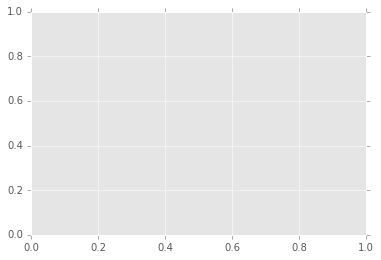

In [8]:
plt.clf()
plt.hist(img_p.real, bins='auto')
plt.title("Histogram of image")
plt.show()

In [ ]:
__author__ = 'Christo Robison'

from PyQt4 import QtGui, QtCore
import sys
import HyperSpecGui
import numpy as np
import matplotlib
matplotlib.use('QT4Agg')
import matplotlib.pylab as pylab

import time
import pyqtgraph
import hs_imFFTW as hs
from spectral import *

CHUNKSZ = 1024
FS = 44100 #Hz

class HyperSpecApp(QtGui.QMainWindow, HyperSpecGui.Ui_MainWindow):
    def __init__(self, parent=None):
        pyqtgraph.setConfigOption('background', 'k')  #before loading widget
        super(HyperSpecApp, self).__init__(parent)
        self.setupUi(self)
        self.updateBtn.clicked.connect(self.update)

        #self.view = pyqtgraph.ViewBox(self.gView0)
        #self.scene = pyqtgraph.ImageItem(self.view)
        STEPS = np.array([0.0, 0.2, 0.6, 1.0])
        CLRS = ['k','r','y','w']
        clrmp = pyqtgraph.ColorMap(STEPS, np.array([pyqtgraph.colorTuple(pyqtgraph.Color(c)) for c in CLRS]))
        data = np.random.normal(size=(100, 200, 200))

        #imv = pyqtgraph.image(data)
        self.ImageView2.setImage(data)

        self.ImageView2.ui.histogram.gradient.setColorMap(clrmp)






        #self.img_array = np.zeros((1000, CHUNKSZ / 2 + 1))

        # bipolar colormap

        #pos = np.array([0., 1., 0.5, 0.25, 0.75])
        #color = np.array([[0, 255, 255, 255], [255, 255, 0, 255], [0, 0, 0, 255], (0, 0, 255, 255), (255, 0, 0, 255)],
#                         dtype=np.ubyte)
        #cmap = pyqtgraph.ColorMap(pos, color)
        #lut = cmap.getLookupTable(0.0, 1.0, 256)
        #self.img.setLookupTable(lut)


        self.pltView1.plotItem.showGrid(True, True, 0.7)
        self.pltView2.plotItem.showGrid(True, True, 0.7)

    def update(self):
        t1 = time.clock()
        points = 100
        # Temp demo code
        #X = np.arange(points)
        #Y = np.sin(np.arange(points) / points * 3 * np.pi + time.time())
        #C = pyqtgraph.hsvColor(time.time() / 5 % 1, alpha=.5)
        #pen = pyqtgraph.mkPen(color=C, width=10)
        #self.pltView0.plot(X, Y, pen=pen, clear=True)
        print("update took %.02f ms" % ((time.clock() - t1) * 1000))
        #if self.chkMore.isChecked():
            #QtCore.QTimer.singleShot(1, self.update)  # QUICKLY repeat


def runKmeans(view, inputImg, clusters=6, iters=300):
    (m, c) = kmeans(inputImg, clusters, iters)
    #mw = pyqtgraph.widgets.MatplotlibWidget.MatplotlibWidget()
    #subplot = form.pltView0.add_subplot(111)
    #form.pltView0.
    for i in range(c.shape[0]):
        view.plot(c[i])
    #form.pltView0.plot(subplot)
    return (m, c)

def adjustLabels(dcb, bkgnd=0.0, unknown=4.0):
    dcb[dcb==0.0] = 5.0
    dcb[dcb==4.0] = 0.0
    dcb[dcb==5.0] = 4.0
    return dcb

def runSpectral(dcb, gt, title = 'dcb'):
    (classes, gmlc, clmap) = runGauss(dcb, gt)
    (gtresults, gtErrors) = genResults(clmap, gt)
    displayPlots(clmap, gt, gtresults, gtErrors, (title+" Gaussian Classifer"))
    return (gtresults, gtErrors)

def runPCA(dcb, gt, title = 'dcb'):
    pc = principal_components(dcb)
    pc_0999 = pc.reduce(fraction=0.999)
    img_pc = pc_0999.transform(dcb)
    (classes, gmlc, clmap) = runGauss(img_pc, gt)
    (gtresults, gtErrors) = genResults(clmap, gt)
    displayPlots(clmap, gt, gtresults, gtErrors, (title+" PCA Gaussian Classifer"))
    return (gtresults, gtErrors)

def genResults(clmap, gt):
    gtresults = clmap * (gt!=0)
    gtErrors = gtresults * (gtresults !=gt)
    return (gtresults, gtErrors)

def runGauss(dcb, gt):
    classes = create_training_classes(dcb, gt)
    gmlc = GaussianClassifier(classes, min_samples=200)
    clmap = gmlc.classify_image(dcb)
    return (classes, gmlc, clmap)

def displayPlots(clmap, gt, gtresults = None, gtErrors = None, title = 'classifier'):
    if (gtresults is None and gtErrors is None):
        (gtresults, gtErrors) = genResults(clmap, gt)
    v0 = imshow(classes=clmap, title=(title+" results"))
    v1 = imshow(classes = gtresults, title=(title+" gt Results"))
    v2 = imshow(classes = gtErrors, title=(title+" Error"))


if __name__=="__main__":
    trainData = hs.getData(filename='D:\-_Hyper_Spec_-\HYPER_SPEC_TEST_RED.h5')
    testData = hs.getData(filename='D:\-_Hyper_Spec_-\HYPER_SPEC_TEST_RED.h5')




    app = QtGui.QApplication(sys.argv)
    form = HyperSpecApp()
    form.show()
    form.update() #start with something
    img = trainData['dcb'][:, :, 343:370]
    img1 = np.swapaxes(img, 2, 0)

    form.ImageView1.setImage(img1)
    mask = hs.genMask(offset=11)
    #form.ImageView2.setImage(mask, levels=[np.amin(mask),np.amax(mask)+.0001])
    #ImageView doesn't seem to display binary arrays very well so add a small value.
    out_dcb = hs.dcbFilter(img)
    form.ImageView1.setImage(out_dcb.real)
    gtbatch = adjustLabels(trainData['classLabels'])
    gt = gtbatch[:, :, 11]
    #form.ImageView2.setImage(gt)

    t = np.swapaxes(out_dcb, 0, 2)
    t = np.swapaxes(t, 0, 1)
    fftImg = t.real.astype(np.float32, copy=False)
    print('SHAPE OF INPUT IMG: ' + str(np.shape(img)))
    print('SHAPE OF FFT OUT: ' + str(np.shape(fftImg)))


    #(m, c) = runKmeans(form.pltView1, testImg)

    view_cube(fftImg)
    (raw_results, raw_Errors) = runSpectral(img, gt, title="Raw")
    (fft_results, fft_Errors) = runSpectral(fftImg, gt, title="FFT")

    (raw_pc_results, raw_pc_Errors) = runPCA(img, gt, title="Raw")
    (fft_pc_results, fft_pc_Errors) = runPCA(fftImg, gt, title="FFT")







    #subplot = form.matWidget0.getFigure().imshow(clmap)
    #form.matWidget0.

    #STEPS = np.array([0, 1, 2, 3, 4])
    #CLRS = ['k', 'r', 'y', 'b', 'w']
    #clrmp = pyqtgraph.ColorMap(STEPS, np.array([pyqtgraph.colorTuple(pyqtgraph.Color(c)) for c in CLRS]))
    #print(clrmp)
    #form.ImageView2.setImage(clmap)

    #form.ImageView2.ui.histogram.gradient.setColorMap(clrmp)

    #form.img.setImage(clmap,auto_levels=False)
    #form.img.show()

    app.exec_()
    print("DONE")